# Simple Movie Recommendation System

Input: 
2 CSV files containing information about movies, genres, users and ratings

Output: 
Predicted ratings per movie per each user based on input data

Movies.csv has three fields namely: 

    MovieId – Unique id for every movie
    Title – Name of the movie
    Genre – Genre of the movie

The ratings.csv file has four fields namely:

    UserId – Unique id for every user
    MovieId – Unique id for each movie
    Rating – The rating given by user to a movie
    Timestamp – Time of rating

## Necessary imports


In [1]:
import sys
#!conda install --yes --prefix {sys.prefix} scikit-learn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda
from keras.layers import Concatenate, Dense, Dropout

warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('seaborn-bright')
%matplotlib inline 


## Displaying data inputs - Ładowanie nowych danych

In [2]:
# Import a module to create a data frame
import pandas as pd
# Import a module to display a link to the file
from IPython.display import FileLink
# Import a module to delete the file
import os
# Create a download function



os.chdir(r"D:\SEMESTR 9\magisterka\zbiory\ml-latest-small")
ratings_data=pd.read_csv("ratings.csv")


#z tego dużego csv z danymi o rezyserach, wez tylko te rzedy, dla którym m_ids jest w ratings

m_ids_list = list(set(ratings_data['movieId']))

#print(m_ids_set)

#załaduj duży zbior
os.chdir(r"E:\movielens - zbiory\movielens +imdb\ml-25m-imdb")
big_data=pd.read_csv("naprawione_notatnik.csv", on_bad_lines='skip')
smaller_data = big_data[['movieId', 'title','genres_ml','year','tconst','writer','actor','director','producer','actress','cinematographer']]
#smaller_data.head(15)
#smaller_data.info()

new_df = smaller_data.loc[smaller_data['movieId'].isin(m_ids_list)]

new_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9436 entries, 0 to 56184
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movieId          9436 non-null   int64  
 1   title            9436 non-null   object 
 2   genres_ml        9436 non-null   object 
 3   year             9425 non-null   float64
 4   tconst           9436 non-null   object 
 5   writer           9436 non-null   object 
 6   actor            9436 non-null   object 
 7   director         9436 non-null   object 
 8   producer         9436 non-null   object 
 9   actress          9436 non-null   object 
 10  cinematographer  9436 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 884.6+ KB


In [3]:
new_df.head(10)

,movieId,title,genres_ml,year,tconst,writer,actor,director,producer,actress,cinematographer
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N
1,2,Jumanji,Adventure|Children|Fantasy,1995.0,tt0113497,nm0378144|nm0852430|nm0833164|nm0885575,nm0000245|nm0404993,nm0002653,nm0472256,nm0000379|nm0001372,\N
2,3,Grumpier Old Men,Comedy|Romance,1995.0,tt0113228,nm0425756,nm0000527|nm0000493,nm0222043,nm0075828|nm0204862,nm0000268|nm0000047,nm0005714
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0,tt0114885,nm0573334|nm0060103,\N,nm0001845,nm0771834|nm0842470,nm0001365|nm0000291|nm0222643|nm0005375,\N
4,5,Father of the Bride Part II,Comedy,1995.0,tt0113041,nm0352443|nm0329304|nm0583600,nm0000188|nm0001737,nm0796124,\N,nm0000473|nm0931090,nm0204567
5,6,Heat,Action|Crime|Thriller,1995.0,tt0113277,\N,nm0000199|nm0000134|nm0000174|nm0000685,nm0000520,nm0513165,\N,nm0005883
6,7,Sabrina,Comedy|Romance,1995.0,tt0114319,nm0713128|nm0853138|nm0000697|nm0499626|nm0070660,nm0000148|nm0001427,nm0001628,\N,nm0000566|nm0545408,\N
7,8,Tom and Huck,Adventure|Children,1995.0,tt0112302,nm0878494|nm0814085|nm0521739,nm0001795|nm0000605|nm0734236|nm0777760,nm0382072,nm0548257|nm0049689,\N,\N
8,9,Sudden Death,Action,1995.0,tt0114576,nm0049945|nm0704164,nm0000241|nm0000959|nm0000855,nm0001382,nm0049920|nm0224537,nm0942925,\N
9,10,GoldenEye,Action|Adventure|Thriller,1995.0,tt0113189,nm0001220|nm0289833|nm0128997|nm0270761,nm0000112|nm0000293,nm0132709,nm0110483,nm0001713|nm0000463,\N


In [4]:
os.chdir(r"D:\SEMESTR 9\magisterka\zbiory\ml-latest-small")
ratings_data=pd.read_csv("ratings.csv")

good_movie_threshold = 3.5

#dodanie lubi / nie lubi, jesli ocen >=4.0, to lubi, a jak mniejsza, to nie lubi
ratings_data['likes'] = [1 if ocena>=good_movie_threshold else 0 for ocena in ratings_data['rating'] ]
ratings_data.head(10)

,userId,movieId,rating,timestamp,likes
0,1,1,4.0,964982703,1
1,1,3,4.0,964981247,1
2,1,6,4.0,964982224,1
3,1,47,5.0,964983815,1
4,1,50,5.0,964982931,1
5,1,70,3.0,964982400,0
6,1,101,5.0,964980868,1
7,1,110,4.0,964982176,1
8,1,151,5.0,964984041,1
9,1,157,5.0,964984100,1


In [5]:
movie_names=pd.read_csv("movies.csv")
#movie_names.head(10)

## Merging data into one dataframe

In [6]:
movie_data=pd.merge(ratings_data,new_df,on='movieId')
movie_data.head(10)

,userId,movieId,rating,timestamp,likes,title,genres_ml,year,tconst,writer,actor,director,producer,actress,cinematographer
0,1,1,4.0,964982703,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N
1,5,1,4.0,847434962,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N
2,7,1,4.5,1106635946,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N
3,15,1,2.5,1510577970,0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N
4,17,1,4.5,1305696483,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N
5,18,1,3.5,1455209816,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N
6,19,1,4.0,965705637,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N
7,21,1,3.5,1407618878,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N
8,27,1,3.0,962685262,0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N
9,31,1,5.0,850466616,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N


## Checking info about users - number of users, mean rating per user

In [7]:
unique_users = pd.DataFrame(movie_data.groupby('userId'))
print('Number of users: ', len(unique_users))

Number of users:  610


In [8]:
mean_rating_per_user=pd.DataFrame(movie_data.groupby('userId')['rating'].mean())
#mean_rating_per_user.head(10)

## Checking info about movies - number of movies, most popular movies, highest rated, lowest rated

In [9]:
unique_movies = pd.DataFrame(movie_data.groupby('title'))
print('Number of movies: ', len(unique_movies))

Number of movies:  9168


In [10]:
highest_rated= pd.DataFrame(movie_data.groupby('title')['rating'].mean().sort_values(ascending=False))
#highest_rated.head(10)

In [11]:
lowest_rated= pd.DataFrame(movie_data.groupby('title')['rating'].mean().sort_values(ascending=True))
#lowest_rated.head(10)

In [12]:
most_popular= pd.DataFrame(movie_data.groupby('title')['rating'].count().sort_values(ascending=False))
#most_popular.head(10)

## Encoding ids

We need to encode movieIds and userIds to make them sequential and beggining at zero to that they don't cloud our model.


In [13]:
encoded_user_ids = LabelEncoder()
movie_data['user'] = encoded_user_ids.fit_transform(movie_data['userId'].values)
n_users = movie_data['user'].nunique()

item_enc = LabelEncoder()
movie_data['movie'] = item_enc.fit_transform(movie_data['movieId'].values)
n_movies = movie_data['movie'].nunique()

movie_data.head(10)

,userId,movieId,rating,timestamp,likes,title,genres_ml,year,tconst,writer,actor,director,producer,actress,cinematographer,user,movie
0,1,1,4.0,964982703,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N,0,0
1,5,1,4.0,847434962,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N,4,0
2,7,1,4.5,1106635946,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N,6,0
3,15,1,2.5,1510577970,0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N,14,0
4,17,1,4.5,1305696483,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N,16,0
5,18,1,3.5,1455209816,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N,17,0
6,19,1,4.0,965705637,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N,18,0
7,21,1,3.5,1407618878,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N,20,0
8,27,1,3.0,962685262,0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N,26,0
9,31,1,5.0,850466616,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,\N,30,0


## Determining max and min rating for normalization

In [14]:
movie_data['rating'] = movie_data['rating'].values.astype(np.float32)
min_rating = min(movie_data['rating'])
max_rating = max(movie_data['rating'])

n_users, n_movies, min_rating, max_rating

(610, 9436, 0.5, 5.0)

## What is our X and y?

X = unique pairs of user and movie values
y = rating values


In [15]:
X = movie_data[['user', 'movie']].values
y = movie_data['rating'].values

## Splitting data into training and testing datasets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90225, 2), (10025, 2), (90225,), (10025,))


## Further enhancements to datasets

We need to set the amount of factors  -based on other solutions 50 factors work the best. It needs to be the same for movies and users.

We also need  to turn users and movies into separate arrays in the training and test data.

In [17]:
n_factors = 50

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

train_df = pd.DataFrame(
    {'train_u_ids': X_train[:, 0].tolist(),
     'train_m_ids': X_train[:, 1].tolist()
    })

test_df = pd.DataFrame(
    {'test_u_ids': X_test[:, 0].tolist(),
     'test_m_ids': X_test[:, 1].tolist()
    })

print('uids: ', X_train[:, 0])

print('mids: ', X_train[:, 1])

uids:  [423 345 107 ... 479  16 482]
mids:  [6691 3464  443 ... 2709   97 2666]


In [18]:
train_df.head(10)

,train_u_ids,train_m_ids
0,423,6691
1,345,3464
2,107,443
3,508,1067
4,390,879
5,488,2597
6,219,5139
7,380,545
8,19,1992
9,482,6647


## Model for training

In [19]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt) #tu dorzuciłam metrics

    return model

In [20]:
model = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        30500       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        471800      ['input_2[0][0]']                
                                                                                              

## Loss and accuracy plots for model

In [21]:
#history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5, verbose=1, validation_data=(X_test_array, y_test))

history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5, verbose=1, validation_data=(X_test_array, y_test))
"""
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()"""

Epoch 1/5
1410/1410 [==============================] - 13s 9ms/step - loss: 0.9118 - val_loss: 0.7517
Epoch 2/5
1410/1410 [==============================] - 12s 9ms/step - loss: 0.7800 - val_loss: 0.7301
Epoch 3/5
1410/1410 [==============================] - 12s 9ms/step - loss: 0.7486 - val_loss: 0.7262
Epoch 4/5
1410/1410 [==============================] - 12s 9ms/step - loss: 0.7343 - val_loss: 0.7266
Epoch 5/5
1410/1410 [==============================] - 12s 9ms/step - loss: 0.7182 - val_loss: 0.7235


"\nplt.plot(history.history['accuracy'])\nplt.plot(history.history['val_accuracy'])\nplt.title('model accuracy')\nplt.ylabel('accuracy')\nplt.xlabel('epoch')\nplt.legend(['train', 'val'], loc='upper left')\nplt.show()"

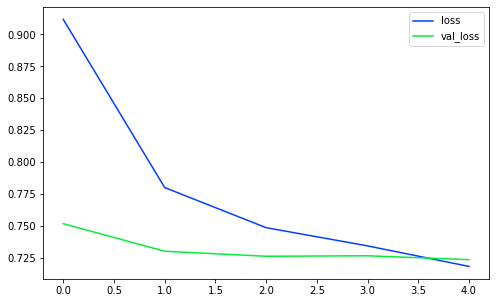

In [22]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

## Predictions vs. actual rating per user

In [23]:


predictions = model.predict([X_test[:, 0], X_test[:, 1]])
actual = y_test

#print('x_test:', type(X_test[:, 0]))
#print('Predictions vs actual: ')

#for i in range(len(y_test)):
    #print('pred: ', predictions[i][0], ', actual: ', actual[i], ', encoded user_id: ', X_test[i,0], ', encoded movie_id: ', X_test[i,1])

#wyswietlamy przewidywana ocene filmu przez danego usera


In [24]:
print(predictions.flatten())


[3.9231572 4.356492  2.6556065 ... 3.1866705 3.5021772 3.9267898]




We need to decode user and movie id


## Recomendations for user 432

In [25]:
user_id_to_recommend = 432

# 1. Znajdz jego zakodowane id w df

encoded_u_id = movie_data.loc[(movie_data['userId'] == user_id_to_recommend)]['user'].tolist()[0]
print('encoded_u_id:', encoded_u_id)                           


# 2. Wez wszystkie encoded m_ids, które nie wystapiły z nim w kombinacji w zbiorze treningowym

## 2.1 Wez wszystkie encoded m_ids
all_encoded_m_ids = set(movie_data['movie'].tolist())


## 2.2 Z tego zbioru wyrzuc te, które były z nim w kombinacji w zbiorze treningowym 


#training_m_ids_for_this_user = set(movie_data.loc[(movie_data['user'] == encoded_u_id)]['movie'].tolist())
#ja sobie tu wyrzucilam wszystkie, a nie treningowe

training_m_ids_for_this_user = set(train_df.loc[(train_df['train_u_ids'] == encoded_u_id)]['train_m_ids'].tolist())


not_training_m_ids_for_this_user = list(set(all_encoded_m_ids) - set(training_m_ids_for_this_user))
#print('not_training_m_ids_for_this_user: ', not_training_m_ids_for_this_user)


# 3. Przewidź oceny dla tego usera i każdego z jego "nieobejrzanych" filmów
user_arr = np.array([encoded_u_id] * len(not_training_m_ids_for_this_user))
print('user_arr', user_arr)

movies_arr = np.array(not_training_m_ids_for_this_user)
print('movies_arr: ', movies_arr)


predictions_for_user = model.predict([user_arr, movies_arr]).flatten()

#for j in range(len(not_training_m_ids_for_this_user)):
    #print('pred: ', predictions_for_user[j], ', encoded user_id: ', encoded_u_id, ', encoded movie_id: ', not_training_m_ids_for_this_user[j])

    

#predictions_df_for_user.head(10)

encoded_u_id: 431
user_arr [431 431 431 ... 431 431 431]
movies_arr:  [   0    2    3 ... 9433 9434 9435]


In [26]:
# 4. Zrób z tego df, posortuj i wyświetl najlepsze filmy

list_of_predictions = predictions_for_user.tolist() 

predictions_df_for_user = pd.DataFrame(
    {'prediction': list_of_predictions,
     'likes_prediction':   [1 if ocena>=4.0 else 0 for ocena in list_of_predictions],
     'user_encoded': user_arr.tolist(),
     'movie_encoded': movies_arr.tolist()
    })

predictions_df_for_user.head(10)

,prediction,likes_prediction,user_encoded,movie_encoded
0,3.808607,0,431,0
1,3.175056,0,431,2
2,2.459842,0,431,3
3,3.122458,0,431,4
4,3.945250,0,431,5
5,3.127189,0,431,6
6,2.994137,0,431,7
7,2.948940,0,431,8
8,3.406104,0,431,9
9,3.583294,0,431,10


In [27]:
# 5. Posortuj, wyświetl najlepsze filmy

predictions_df_for_user['movieId'] = item_enc.inverse_transform(predictions_df_for_user['movie_encoded'].values)
predictions_df_for_user['u_ids_decoded'] = encoded_user_ids.inverse_transform(predictions_df_for_user['user_encoded'].values)

sorted_df = predictions_df_for_user.sort_values(by=['prediction'], ascending=False)
sorted_df.head(10)



,prediction,likes_prediction,user_encoded,movie_encoded,movieId,u_ids_decoded
9092,4.599841,1,431,9314,177593,432
2489,4.524359,1,431,2575,3451,432
4254,4.486599,1,431,4382,6460,432
1523,4.471488,1,431,1584,2131,432
845,4.447348,1,431,879,1178,432
2320,4.425312,1,431,2405,3201,432
4628,4.414414,1,431,4765,7121,432
2127,4.413236,1,431,2205,2937,432
5305,4.395254,1,431,5458,26326,432
4938,4.378622,1,431,5084,8132,432


## Show recommendations for this user

In [28]:
to_recommend = pd.merge(sorted_df,movie_names,on='movieId')
to_recommend[['prediction', 'title']].head(20)

,prediction,title
0,4.599841,"Three Billboards Outside Ebbing, Missouri (2017)"
1,4.524359,Guess Who's Coming to Dinner (1967)
2,4.486599,"Trial, The (Procès, Le) (1962)"
3,4.471488,Autumn Sonata (Höstsonaten) (1978)
4,4.447348,Paths of Glory (1957)
5,4.425312,Five Easy Pieces (1970)
6,4.414414,Adam's Rib (1949)
7,4.413236,"Palm Beach Story, The (1942)"
8,4.395254,"Holy Mountain, The (Montaña sagrada, La) (1973)"
9,4.378622,Gladiator (1992)
